# Model Evaluation & Validation
## By Yosry Negm

<br><hr><br>
In this project, I will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

The code below loads the Boston housing dataset, along with a few of the necessary Python libraries required for this project. <br>
>**Note:** The dataset will be loaded successfully if the size of the dataset is reported.


In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl  # Display inline matplotlib plots with IPython
from sklearn.model_selection import learning_curve ,validation_curve,GridSearchCV
from sklearn.model_selection import  ShuffleSplit, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,make_scorer
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
# Pretty display for notebooks
%matplotlib inline  


In [2]:
# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration
First section of this project, to better understand and justify the results. I will make a cursory investigation about the Boston housing data with an explorative process which is considered a fundamental practice Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, I will separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

In [3]:
minimum_price = np.min(prices)
maximum_price = np.max(prices)
mean_price = np.mean(prices)
median_price = np.median(prices)
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105000.0
Maximum price: $1024800.0
Mean price: $454342.9447852761
Median price $438900.0
Standard deviation of prices: $165171.13154429474


We are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

** for each of the three features above, We may ask ourselves do an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`? **

**Actually we observe that : **

-  ### intuition for the First Feature 'RM' :
> As the number of rooms increases (this means bigger houses) ,the price will go expensive i.e. value(number of rooms) of 6 be worth less than a home that has an 'RM' value of 7.
-  ### intuition for the Second Feature 'LSTAT' :
> Since the area has more poor and lower class habitants ,so the prices expected to be low i.e. value(percent of lower class workers) of 15 have home prices be worth more than a neighborhood that has an 'LSTAT' value of 20.
-  ### intuition for the Third Feature 'PTRATIO' :
> Because 'PTRATIO' indicates the education resources(Teachers as compared by students) ,hence because of limited eduacation resources the prices could be low  for lower ratios and higher for the high ratios, i.e. value(ratio of students to teachers) of 10 have home prices be worth more than a neighborhood that has an 'PTRATIO' value of 15.

----

## Developing the Model
In this section of the project, I will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in our predictions.

### Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify our model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

The code below is for the `performance_metric` by using  `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict` and the the performance score will be assigned to the `score` variable.

In [4]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
 
    score = r2_score(y_true, y_predict)
   
    # Return the score
    return score

### Goodness of Fit
If we have assumed that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

The code below will use the `performance_metric` function and calculate this model's coefficient of determination.

In [5]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


* The R2 score is the proportion of the variance in the dependent variable that is predictable from the independent variable. In other words:
 * R2 score of 0 means that the dependent variable cannot be predicted from the independent variable.
 * R2 score of 1 means the dependent variable can be predicted from the independent variable.
 * R2 score between 0 and 1 indicates the extent to which the dependent variable is predictable. An 
 * R2 score of 0.40 means that 40 percent of the variance in Y is predictable from X.
* Therefore, If we ask ourselves would we consider this model to have successfully captured the variation of the target variable? <br>
We will note  that model has <font color='green'> successfully </font> captured the variations of the target variable. 
The reason is that the model has <i>coefficient of determination</i> ($R^{2}$) equal to <b> 0.923</b> and this value is <font color='red'> very close </font> to 1 which means that the predicted values are <b> highly good</b>.

### Shuffle and Split Data
our next step requires that we take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

In the code below, we will use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets. Then split the data into 80% training and 20% testing. And then set the `random_state` for `train_test_split` to a suitable value. This ensures results are consistent. Finally assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.


In [6]:
# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=42)
# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### Training and Testing

* The benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm :

By thinking about how overfitting or underfitting is contingent upon how splits on data is done, we could conclude that for testing and validating our predictive model ,which means discovering if there's an error due to <b>bias</b> (<font color='red'> Underfitting</font>) or an error due to <b>variance </b>(<font color='red'>Overfitting</font>) and this will enable us to check for the generalization of the trained model(<b>Measuring Generalization</b>) i.e. observing the model performance on a data set which hasn't been seen by our model.In this case of model evaluation we will depend on true values for the unseen datain order to compare the model predictions and that is a great reason to split the overall dataset into two subsets ,one for training the model and the other for measuring model performance on unseen data (Testing), since if we had used the overal dataset for training we wouldn't be able to test it.But we should note that splitting the overall dataset into training and testing subsets doesn't always necessarily impact how well the training of the model is or how well it generalizes on unseen data and what we could say here that the main effective  facor may be how much relevant information is contained in the dataset and sometimes we need more data to get a better trained model (it doesn't depend on data split).
we also need to know that during splitting our overall dataset into to training dataset and testing dataset to fit our model on the training dataset in order to make predictions on the test dataset,it might be happen one of two thing: first either we may overfit our model i.e. the model finds <b>perfect pattern</b> over training data only but it fails on test data i.e. it <b> just memorized</b> it and fail for the newer ones(<b>can't be generalized well</b>). Second we may underfit our model i.e the model hasn't understand any pattern from our data. 

----

## Analyzing Model Performance
I'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, and investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing the model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. we note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.

In [7]:
def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([1,3,6,10]):
        
        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, test_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')
        
        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

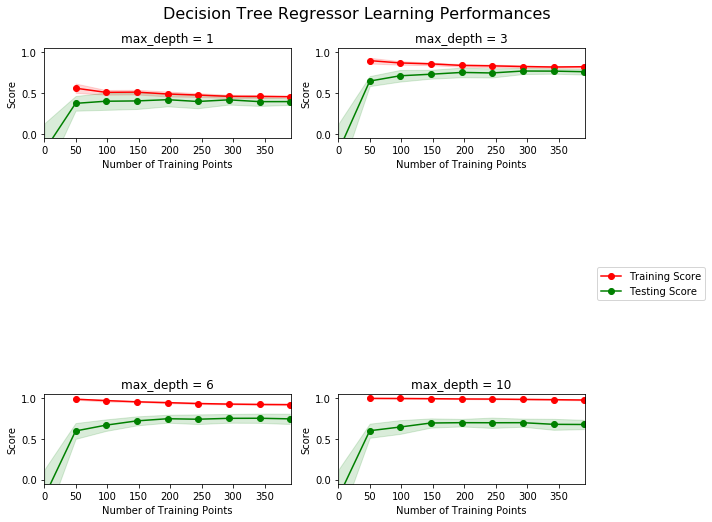

In [8]:
# Produce learning curves for varying training set sizes and maximum depths
ModelLearning(features, prices)

If we looked at the Graph with maximum depth equal to <font color='red'><b> 3 </b></font> we will notice that when adding more training points ,the score of the training decreases , because more data points increases the difficulty of fitting them.
> The testing score is increased by the number of traing points , because adding more training points help to accurate testing.
And Adding more training points will not benefit the model very much.

### Complexity Curves
The following code produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  


In [9]:
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    pl.figure(figsize=(7, 5))
    pl.title('Decision Tree Regressor Complexity Performance')
    pl.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    pl.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    pl.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    pl.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    pl.legend(loc = 'lower right')
    pl.xlabel('Maximum Depth')
    pl.ylabel('Score')
    pl.ylim([-0.05,1.05])
    pl.show()

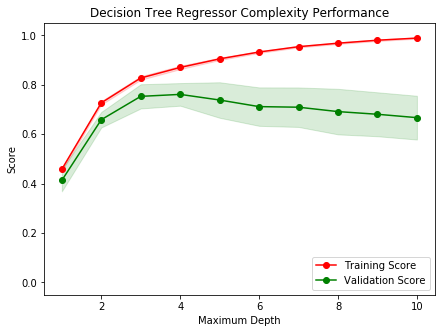

In [10]:
ModelComplexity(X_train, y_train)

### Bias-Variance Tradeoff

High bias is a sign of underfitting(model is not complex enough to pick up the nuances in the data) and high variance is a sign of overfitting(model is by-hearting the data and cannot generalize well). So, if we think about which model(depth 1 or 10) aligns with which part of the tradeoff of suffering from high bias or from high variance we will notice:-
- When the model is trained with <b>maximum depth of 1</b> , the modell will suffer from<b> <font color='red'>High Bias</font></b>.
> because training score and testing score are too small and close to each other.
- When the model is trained with <b>maximum depth of 10</b> , the modell will suffer from<b> <font color='red'>High Variance</font></b>.
> the model looks fits googd for training set at value ($R^{2}$=1) , however it may overfitted because the score of testing set is very low.

### Best-Guess Optimal Model

If we want to know which maximum depth will result in a model that best generalizes to unseen data and what intuition lead you to this, we should look at the graph above and see where the validation scores lie for the various depths that have been assigned to the model. Does it get better with increased depth? At what point do we get our best validation score without overcomplicating our model? remembering that, Occams Razor states "Among competing hypotheses, the one with the fewest assumptions should be selected.",. Hence, we will get that by inspecting the graph it looks like that the value of maximum depth should be <b>4</b> to best generalizes to unseen data because by this value,the training score and testing score will be nearly good.

-----

## Evaluating Model Performance
Finally, I will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Grid Search

Grid search technique is a mechanism of performing hyper parameter optimization.
It is done by scanning the data to configure optimal parameters for a given model(Manaul specifying subset of hyper parameters).
-It is used to determine the best parameter to use for any given model.
> it is typically measered by cross validation on traing set.It iterates through every parameters combination and stores a model for each.
-It is extereme computionally expensive and may take long time to run.
<p>Example is SVM parameres tuning such as 'C','gama' ,other example parameters such as maximum depth ,class weight and estimator</p>.

### Cross-Validation

## k-fold cross validation
k-fold cross validation is a technique used to estimate how the model is good on new data(<b>algorithm validation technique</b>).The main purpose of k-fold cross validation is to get an <b> unbiased estimate </b> of model generaliztion on unseen data When we get different models from different folds by <b>averaging</b> out the evaluation metric of all the models.
- It is done by partioning the original sample randomly into<b> <font color='green'>k equal sized subsamples</font></b>.
from these <b>k subsamples</b>, a single subsample is selected as the validation data for testing the model
and the remaining k − 1 subsamples are used as training data (<i>each of the k subsamples used exactly once as the validation </i>data).Then we calculate the average of the resulting from the k folds  to get a single measure.</p>

## Benefit of the application of K-fold CV on grid search
<p>
we apply K-fold CV on grid search To get rid of any bias towards a specific arrangement and composition of data.And this because there is a risk may occuer when using the train-test split method to evaluate model or choose best hyper parameters which appears for The data set in the fixed train-test method which in turn may result in optimum hyper-parameter combination that is good for only particularly arranged training dataset.
</p>
- We take one hyperparameter combination from the grid and keep it constant for one round of whole k-fold cross validation    process.The whole splitting into kfolds, training and validating on one fold and so on.
- This helps us in getting an unbiased estimate of model evaluation metric which helps us decide in a more unbiased way,
 whether the given combination of hyperparameters is best for the particular data set or not. This process is repeated for all combinations of hyperparameters in the grid.


### Fitting a Model
Now we will bring everything together and train a model using the **decision tree algorithm**. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, we will use `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique we described above, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. 

For the `fit_model` function in the code below, we will need to implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.
  

In [11]:


def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    regressor = DecisionTreeRegressor(random_state=0)
    params = {'max_depth': list(range(1,11))}
    scoring_fnc = make_scorer(performance_metric)
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scoring = scoring_fnc, cv = cv_sets)
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. we can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Optimal Model

The code block below fits the decision tree regressor to the training data and produce an optimal model.

In [14]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


Note that the Parameter 'max_depth' is 4 for the optimal model.
which is the same as the value we guessed before.

### Predicting Selling Prices
Imagine that we were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. we have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* What price would we recommend each client sell his/her home at? 
* Do these prices seem reasonable given the values for the respective features? 

Of the three clients, client 3 has has the biggest house, in the best public school neighborhood with the lowest poverty level; while client 2 has the smallest house, in a neighborhood with a relatively high poverty rate and not the best public schools.

The code block below shows the optimized model make predictions for each client's home.

In [15]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $403,025.00
Predicted selling price for Client 2's home: $237,478.72
Predicted selling price for Client 3's home: $931,636.36


## Selling prices predicted by the model for the three houses(in dolars) :
- Predicted selling price for Client 1's home: 403,025.00
- Predicted selling price for Client 2's home: 237,478.72
- Predicted selling price for Client 3's home: 931,636.36
### The statistics of the dataset (in dolars): 
- Minimum price: 105,000.00
- Maximum price: 1,024,800.00
- Mean price:    454,342.94
- Median price : 438,900.00
- Standard deviation of prices: 165,171.13
### Justification: 
<p>
for the Client No.1,  price is 403,025.00, which is near to  average normal housing price in Boston and is also in the  standard deviation. 
features 'RM', 'LSTAT', and 'PTRATIO' are  between the other two houses. hence, I think this prediction is logical.
</p>
<p>
for the Client No. 2,price is 237,478.72, which is lower than  average price and  between one and two standard deviation. The house has less rooms than the others, and has higher 'LSTAT' and 'PTRATIO' feature. all these factors will decrease the price. hence, I think this prediction is reasonable.
</p>
<p>
for the Client No. 3, the price is 931,636.36, which is much higher than  average price and near to  maximum price . It is more than three standard deviation. This house  have a lot of rooms (eight rooms) and very low LSTAT. The PTRATIO feature is close to those of the first Client. therefore, this house is very ideal  for this dataset and should be viewed with detailing. hence, we may need more inspection on the prediction of such house.
</p>

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

The code below shows the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.**

In [16]:
def PredictTrials(X, y, fitter, data):
    """ Performs trials of fitting and predicting data. """

    # Store the predicted prices
    prices = []

    for k in range(10):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = k)
        
        # Fit the data
        reg = fitter(X_train, y_train)
        
        # Make a prediction
        pred = reg.predict([data[0]])[0]
        prices.append(pred)
        
        # Result
        print("Trial {}: ${:,.2f}".format(k+1, pred))

    # Display price range
    print("\nRange in prices: ${:,.2f}".format(max(prices) - min(prices)))

In [17]:
PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $424,935.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $73,357.39


### Applicability

I think this model doesn't fit with reality right now because it uses old data
and not matching the recent changes such as infaltion and changes in the used features in that model and more as described below:-
- since this model's data gathered in 1978,It is old and out of date and may be not suitable to figuare today's people trends. Also, I think Housing prices tend to rise with inflation and economic situations,it isn't really possible to predict inflation and we noted that these factors hadn't taken into consideration via this model. 
- The features used in this model may also changed by the time and didn't have the same impact as before,e.g.  'PTRATIO' feature may not be as important as before since people now have more means to reach schools more far and some schools afford buses to pickup students and so on.
- New modern factors are come to control housing prices. Hence, prices nowadays depend on more diffrent features than the past ,we could mention some examples like provided services,traffic,welfare means and shoping places,square feet of the house ,quality of appliances,presence of swiming pools,.. and more.So I think these factors must taken into consideration as features within the model in order to give a good prediction as possible  i.e. need to have more features instead of three features it could grow up to 10 or more.
- From the above results ,we found that for 10 different trials, the predictions are all different,changes from 351,577.61 to 424,935.00. The range in prices is 73,357.39.It seems that the prediction has large variation.I isn't robust system and doesn't give consistent results.
- The collected  data from an urban citites such as Boston wouldn't  be suitable in another citity like one in rural cities,So it is not a veratile model and it is limited to certain domain in which data were collected.
- Judging the price of an individual home based on the characteristics of the entire neighborhood is a common habit. And in most of common cases in real estate pricing we depend on the surrounding circumistances and conditions i.e the house price is highly affected by the neighbourhood houses' prices howerver this is unfair,expect in certain outlier cases in which the buyer is valuing the house for certain interest.
I could conclude that this model must be revised and modified to accommodate up to date data and taking modern factors and changes into considerations.